# 7.Image Denoising

In [37]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation
from keras.models import Model
import random
import warnings
warnings.filterwarnings('ignore')

### Include changes to original codes

In [38]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    x = generate_a_drawing(figsize, U, V, noise)
    y = generate_a_drawing(figsize, U, V, 0)
    return [x, y]

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    x = generate_a_drawing(figsize, U, V, noise)
    y = generate_a_drawing(figsize, U, V, 0)
    return [x, y]

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    x = generate_a_drawing(figsize, U, V, noise)
    y = generate_a_drawing(figsize, U, V, 0)
    return [x, y]

# Make some changes to remove the noise

def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im1, im2 = generate_a_rectangle()
    im_size = im1.shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i, end=' ')
        category = np.random.randint(3)
        noise=np.random.randint(100)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk(noise, free_location)
        else:
            [X[i], Y[i]] = generate_a_triangle(noise, free_location)
    X = X / 255.0
    Y = Y / 255.0
    return [X, Y]

def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, True)
    return [X_test, Y_test]

In [39]:
[X_train_noise, X_train_clean] = generate_dataset_denoising(300, True)
[X_test_noise, X_test_clean] = generate_test_set_denoising()

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

In [40]:
x_train_clean = X_train_clean.reshape(len(X_train_clean), 72, 72, 1)
x_train_noise = X_train_noise.reshape(len(X_train_noise), 72, 72, 1)
x_test_clean = X_test_clean.reshape(len(X_test_clean), 72, 72, 1)
x_test_noise = X_test_noise.reshape(len(X_test_noise), 72, 72, 1)

In [41]:
input_img = Input(shape=(72, 72, 1))

### Compile the model

In [42]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [43]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [44]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [45]:
autoencoder.fit(x_train_noise, x_train_clean, epochs=10, batch_size=32, shuffle=True, validation_data=(x_test_noise, x_test_clean))

Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 31s 103ms/step - loss: 0.5249 - acc: 0.8069 - val_loss: 0.2246 - val_acc: 0.9156
Epoch 2/10
300/300 [==============================] - 31s 105ms/step - loss: 0.2166 - acc: 0.9173 - val_loss: 0.1824 - val_acc: 0.9587
Epoch 3/10
300/300 [==============================] - 31s 102ms/step - loss: 0.1184 - acc: 0.9624 - val_loss: 0.0699 - val_acc: 0.9869
Epoch 4/10
300/300 [==============================] - 31s 102ms/step - loss: 0.0452 - acc: 0.9871 - val_loss: 0.0292 - val_acc: 0.9899
Epoch 5/10
300/300 [==============================] - 30s 102ms/step - loss: 0.0293 - acc: 0.9898 - val_loss: 0.0262 - val_acc: 0.9912
Epoch 6/10
300/300 [==============================] - 31s 103ms/step - loss: 0.0255 - acc: 0.9912 - val_loss: 0.0236 - val_acc: 0.9916
Epoch 7/10
300/300 [==============================] - 31s 102ms/step - loss: 0.0237 - acc: 0.9916 - val_loss: 0.0206 - val_acc: 0.9926
Epoch 8/1

### Make the prediction

In [46]:
x_pred_clean = autoencoder.predict(x_test_noise, batch_size=32)

### Take some samples

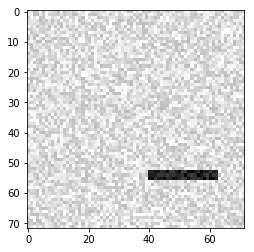

In [47]:
plt.imshow(x_test_noise[0].reshape(72,72), cmap='gray')

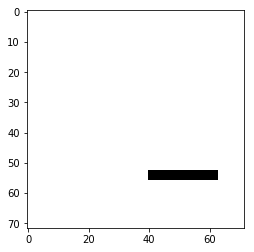

In [48]:
plt.imshow(x_test_clean[0].reshape(72,72), cmap='gray')

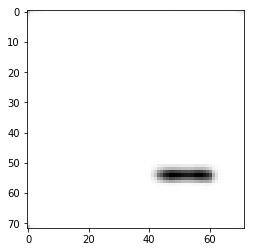

In [49]:
plt.imshow(x_pred_clean[0].reshape(72,72), cmap='gray')

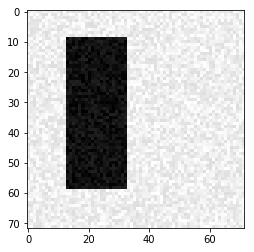

In [50]:
plt.imshow(x_test_noise[88].reshape(72,72), cmap='gray')

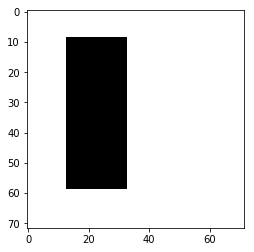

In [51]:
plt.imshow(x_test_clean[88].reshape(72,72), cmap='gray')

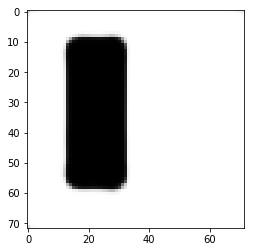

In [52]:
plt.imshow(x_pred_clean[88].reshape(72,72), cmap='gray')

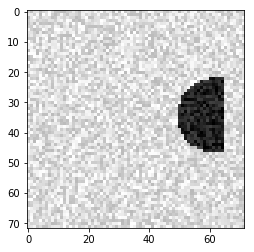

In [53]:
plt.imshow(x_test_noise[99].reshape(72,72), cmap='gray')

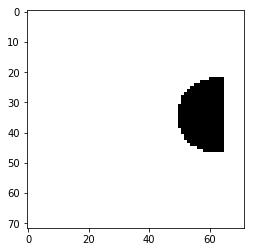

In [54]:
plt.imshow(x_test_clean[99].reshape(72,72), cmap='gray')

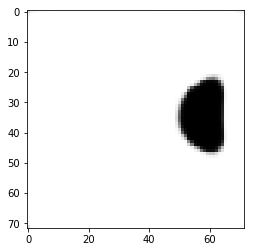

In [55]:
plt.imshow(x_pred_clean[99].reshape(72,72), cmap='gray')

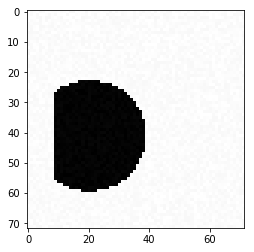

In [56]:
plt.imshow(x_test_noise[162].reshape(72,72), cmap='gray')

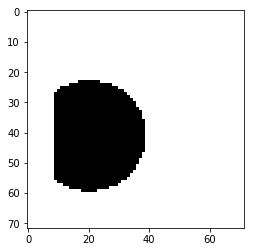

In [57]:
plt.imshow(x_test_clean[162].reshape(72,72), cmap='gray')

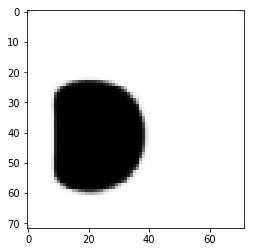

In [58]:
plt.imshow(x_pred_clean[162].reshape(72,72), cmap='gray')